# Attention Distance Analysis
Compare attention distance between GPT2 and the randomly initialized model.

In [1]:
import numpy as np
import torch
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
from sample_batch_data import get_data_info, get_batch
from signal_propagation import get_activation

In [2]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

## Plot Attention Distance Gap

  0%|          | 0/2 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87


  0%|          | 0/2 [00:00<?, ?it/s]

Loading from pretrained


/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_hopper_666_K1/model_4.pt
Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87


  0%|          | 0/2 [00:00<?, ?it/s]

Loaded from ../../checkpoints/dt_medium_hopper_666_K1/model_4.pt


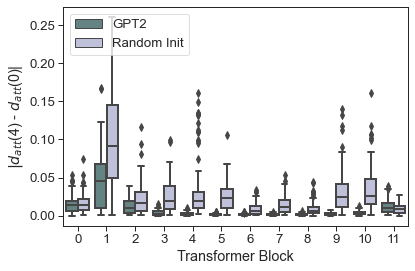

In [18]:

seed=666
models=['gpt2', 'dt']
epoch1=0
epoch2=4
env_name='hopper'
path_to_model_checkpoint = 'path_to_model_checkpoint'
path_to_save_att_dist_diff = 'path_to_save_att_dist_diff'
path_to_save_figure = 'path_to_save_figure'
path_to_dataset = 'path_to_dataset'

dataset_name = 'medium'

att_dist_diff_abs_list = []

for model_name in tqdm(models):
    model1 = model_name
    model2 = model_name
    
    torch.manual_seed(seed)

    if model1 == 'gpt2':
        pretrained_lm1 = 'gpt2'
    elif model1 == 'clip':
        pretrained_lm1 = 'openai/clip-vit-base-patch32'
    elif model1 == 'igpt':
        pretrained_lm1 = 'openai/imagegpt-small'
    elif model1 == 'dt':
        pretrained_lm1 = False

    variant = {
        'embed_dim': 768,
        'n_layer': 12,
        'n_head': 1,
        'activation_function': 'relu',
        'dropout': 0.2, # 0.1
        'load_checkpoint': False if epoch1==0 else f'{path_to_model_checkpoint}/{model1}_medium_{env_name}_{seed}_K1/model_{epoch1}.pt',
        'seed': seed,
        'outdir': f"tmp/{model1}_{dataset_name}_{env_name}_{seed}",
        'env': env_name,
        'dataset': dataset_name,
        'model_type': 'dt',
        'K': 20, # 2
        'pct_traj': 1.0,
        'batch_size': 100,  # 64
        'num_eval_episodes': 100,
        'max_iters': 40,
        'num_steps_per_iter': 2500,
        'pretrained_lm': pretrained_lm1,
        'gpt_kmeans': None,
        'kmeans_cache': None,
        'frozen': False,
        'extend_positions': False,
        'share_input_output_proj': True
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    state_dim, act_dim, max_ep_len, scale = get_data_info(variant)
    states, actions, rewards, dones, rtg, timesteps, attention_mask = get_batch(variant, state_dim, act_dim, max_ep_len, scale, device, path_to_dataset)

    att_dist_mat_list = []
    for _ in tqdm(range(2)):

        activation = get_activation(variant, state_dim, act_dim, max_ep_len, states, actions, rewards, rtg, timesteps, attention_mask)

        if model2 == 'gpt2':
            pretrained_lm2 = 'gpt2'
        elif model2 == 'clip':
            pretrained_lm2 = 'openai/clip-vit-base-patch32'
        elif model2 == 'igpt':
            pretrained_lm2 = 'openai/imagegpt-small'
        elif model2 == 'dt':
            pretrained_lm2 = False

        variant['load_checkpoint'] = False if epoch2==0 else f'{path_to_model_checkpoint}/{model2}_medium_{env_name}_{seed}_K1/model_{epoch2}.pt'
        variant['outdir'] =  f"tmp/{model2}_{dataset_name}_{env_name}_{seed}"
        variant['pretrained_lm'] = pretrained_lm2

        att_dist_mat = []
        layers = np.arange(24) if model_name  == 'igpt' else np.arange(12)

        for batchid in range(variant["batch_size"]):

            att_dist_list = []

            for layer in layers:

                query = activation[f'{layer}.attn.c_attn'][batchid, :, :768]  # 0, 5, 11
                key = activation[f'{layer}.attn.c_attn'][batchid, :, 768: 1536]  # 0, 5, 11

                att_weight_mat = torch.tril(torch.softmax(torch.matmul(query, key.t()) / np.sqrt(768), dim=1))

                dist_mat = np.zeros_like(att_weight_mat)
                for i in range(dist_mat.shape[0]):
                    for j in range(dist_mat.shape[1]):
                        dist_mat[i, j] = abs(i - j)

                dist_mat *= np.array(att_weight_mat)
                att_dist = np.mean(dist_mat)

                att_dist_list.append(att_dist)

            att_dist_mat.append(att_dist_list)

        att_dist_mat_list.append(att_dist_mat)

    att_dist_diff_abs = np.abs(np.array(att_dist_mat_list[0]) - np.array(att_dist_mat_list[1]))

    np.save(f'{path_to_save_att_dist_diff}/att_dist_diff_{epoch1}_{epoch2}_{model_name}_{env_name}_{dataset_name}_{seed}_K1.npy', att_dist_diff_abs)

    if model_name == 'igpt':
        att_dist_diff_abs_normalized = np.zeros((variant["batch_size"], len(layers) // 2))
        for batch_id in range(variant["batch_size"]):
            att_dist_diff_abs_normalized_persample = []
            for i in range(att_dist_diff_abs_normalized.shape[1]):
                att_dist_diff_abs_normalized_persample.append(att_dist_diff_abs[batch_id, i * 2: (i + 1) * 2].mean())
            att_dist_diff_abs_normalized[batch_id, :] = att_dist_diff_abs_normalized_persample
        att_dist_diff_abs = att_dist_diff_abs_normalized

    att_dist_diff_abs_list.append(att_dist_diff_abs)

att_dist_diff_abs_cat = list(np.concatenate(att_dist_diff_abs_list).flatten())
model_name = ['GPT2' for _ in range(1200)] + ['Random Init' for _ in range(1200)]
block_id = list(np.array([[i for i in range(12)] for _ in range(200)]).flatten())

df = pd.DataFrame({
    'att_dist': att_dist_diff_abs_cat,
    'model_name': model_name,
    'block_id': block_id
})

sns.boxplot(x='block_id', y='att_dist', data=df, hue='model_name', palette={"GPT2": (0.372, 0.537, 0.537), "Random Init": (0.733, 0.737, 0.870)})
plt.xlabel('Transformer Block')
plt.ylabel(r'$|d_{att}$' + f'({epoch2}) - ' + r'$d_{att}$' + f'({epoch1})|')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(f'{path_to_save_figure}/att_dist_diff_{epoch1}_{epoch2}_gpt2_dt_{env_name}_{dataset_name}_{seed}_K1.pdf')
plt.show()
            